# **Predicting Water Pump Functionality in Tanzania : Machine Learning Approach to Enhance Resource Allocation**


### **Business Understanding**

### Overview

Tanzania is in the midst of a crisis, out of its 65 million population, 55%  and 11% of rural and urban population respectively, do not have access to clean water. People living under these circumstances, particularly women and girls, spend a significant amount of time traveling long distances to collect water.This poses significant risks in public health, economic productivity and educational opportunities.Now more than everaccess to safe water at home is critical to families in Tanzania.

####      Problem Statement

Access to clean and functional water points is vital for rural and urban communities in Tanzania. However, many wells in Tanzania are either non-functional or require repairs, affecting water accessibility and community well-being.

The central question is: **How can we predict the functionality of water points to prioritize maintenance and improve resource allocation?**

####    Key Stakeholders

Tanzanian Government Agencies, NGOs, Community Leaders, Technical Team (Engineers and Technicians)



### Business goals

- **Optimize resource allocation :** Predict well functionality to prioritize repairs for non-functional and poorly functioning wells . 

- **Improve community access to clean water :** Reduce repairs downtime and increase availability of functional water points

- **Support sustainability and durability of wells :** Provide insights to future installations and maintenance strategies. What factors contribute to well failures?

### **Proposed Solution (Metric : Accuracy Score >= 80%)**

Develop a machine learning model to accurately predict the functionality status of water wells (functional, non-functional, functional needs repair) based on available data.
 
This model will enable repair prioritization, informed decision making (data-driven), and improvement of water access

####    Objectives
-  Develop a Predictive Model: Create a machine learning model that accurately predicts the functionality status of water wells using features like pump type, region and other relevant factors.

-  Identify Key Predictors: Analyze the model to identify the key factors that contribute to well functionality or failure, providing insights that can inform future well design and maintenance strategies.

### **Data Understanding**

The dataset provided on https://www.drivendata.org/ by **Taarifa** and the **Tanzanian Ministry of Water**. More details on the competition could be found [here](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/page/23/).
Feature description for the data can be found in [data description](data_description.txt).
The two datasets we will use are [Training set values](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/data/) and [Training set labels](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/data/)
##### **Data assumptions :**
- The dataset is representative of all wells in Tanzania
- Historical data trends will hold for future predictions

### **Methodology**

### **Import Libraries**

In [141]:
import pandas as pd
import numpy as np
import sys
import os

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Machine learning
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,ConfusionMatrixDisplay

# Feature selection and engineering
from sklearn.feature_selection import RFE

#Model evaluation
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

# Add the parent directory of 'modules' to sys.path
sys.path.append(os.path.abspath("../modules"))

# Now import
from modules.EDA import EDA
from modules.dataprocessor import DataProcessor
from modules.testprocessor import TestDatasetProcessor

### **Load Dataset**

In [35]:
# Load the dataset
df = pd.read_csv("./data/wells_data_cleaned.csv")
# Check the first few rows to confirm the structure
df.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,basin,region,...,construction_year,extraction_type_class,management_group,payment_type,quality_group,quantity,source_class,waterpoint_type,status_group,year_recorded
0,69572,6000.0,2011-03-14,ROMAN,1390.0,ROMAN,34.938093,-9.856322,LAKE NYASA,IRINGA,...,1999,GRAVITY,USER-GROUP,ANNUALLY,GOOD,ENOUGH,GROUNDWATER,COMMUNAL STANDPIPE,FUNCTIONAL,2011
1,8776,0.0,2013-03-06,GRUMETI,1399.0,GRUMETI,34.698766,-2.147466,LAKE VICTORIA,MARA,...,2010,GRAVITY,USER-GROUP,NEVER PAY,GOOD,INSUFFICIENT,SURFACE,COMMUNAL STANDPIPE,FUNCTIONAL,2013
2,34310,25.0,2013-02-25,LOTTERY CLUB,686.0,WORLD VISION,37.460664,-3.821329,PANGANI,MANYARA,...,2009,GRAVITY,USER-GROUP,PER BUCKET,GOOD,ENOUGH,SURFACE,COMMUNAL STANDPIPE MULTIPLE,FUNCTIONAL,2013
3,67743,0.0,2013-01-28,UNICEF,263.0,UNICEF,38.486161,-11.155298,RUVUMA / SOUTHERN COAST,MTWARA,...,1986,SUBMERSIBLE,USER-GROUP,NEVER PAY,GOOD,DRY,GROUNDWATER,COMMUNAL STANDPIPE MULTIPLE,NON FUNCTIONAL,2013
4,19728,0.0,2011-07-13,ACTION IN A,0.0,ARTISAN,31.130847,-1.825359,LAKE VICTORIA,KAGERA,...,0,GRAVITY,OTHER,NEVER PAY,GOOD,SEASONAL,SURFACE,COMMUNAL STANDPIPE,FUNCTIONAL,2011


In [72]:
df.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'basin', 'region', 'lga',
       'population', 'public_meeting', 'scheme_management', 'permit',
       'construction_year', 'extraction_type_class', 'management_group',
       'payment_type', 'quality_group', 'quantity', 'source_class',
       'waterpoint_type', 'status_group', 'year_recorded'],
      dtype='object')

### **Exploratory Data Analysis**

- Data cleaning has been conducted in [data preparation](./notebooks/1.0%20Data%20Preparation.ipynb).
- Initial exploratory analysis has been done in this [file](./notebooks/2.0%20EDA.ipynb). We will have a more summarised form of EDA in this `index.ipynb` file.


In [49]:
# Summary of the target value
df.status_group.value_counts(normalize=True)

FUNCTIONAL                 0.543081
NON FUNCTIONAL             0.384242
FUNCTIONAL NEEDS REPAIR    0.072677
Name: status_group, dtype: float64

- Class imbalances observed with 54% of dataset being Functional wells, while Functional needs repair only has 7% of data

In [81]:
# Function to plot a stacked bar graph
def plot_stackedbar(table, title, figsize):
    """
    Parameters:
    - table: Crosstab DataFrame (e.g., from pd.crosstab)
    - title: Title of the plot
    - figsize: Tuple specifying the figure size
    """
    # colors
    water_cmap = LinearSegmentedColormap.from_list("water_theme", ["#00FFFF", "#008080", "#00008B"])
    # plot
    table.plot(kind="barh", stacked=True, figsize=figsize, colormap=water_cmap, alpha=0.8)
    plt.title(title, loc="left",fontsize=20, pad=40)
    plt.xticks(rotation=45)
    plt.legend(title="Well Status", fontsize=14, loc='upper left', 
        bbox_to_anchor=([0.38, 1.1, 0.58, 0]), 
        ncol=len(table.columns),frameon=True)
    plt.tight_layout()
plt.show()

- A look at visualization between categorical column and the target group (status_group)

 ` Well functionality status by region`

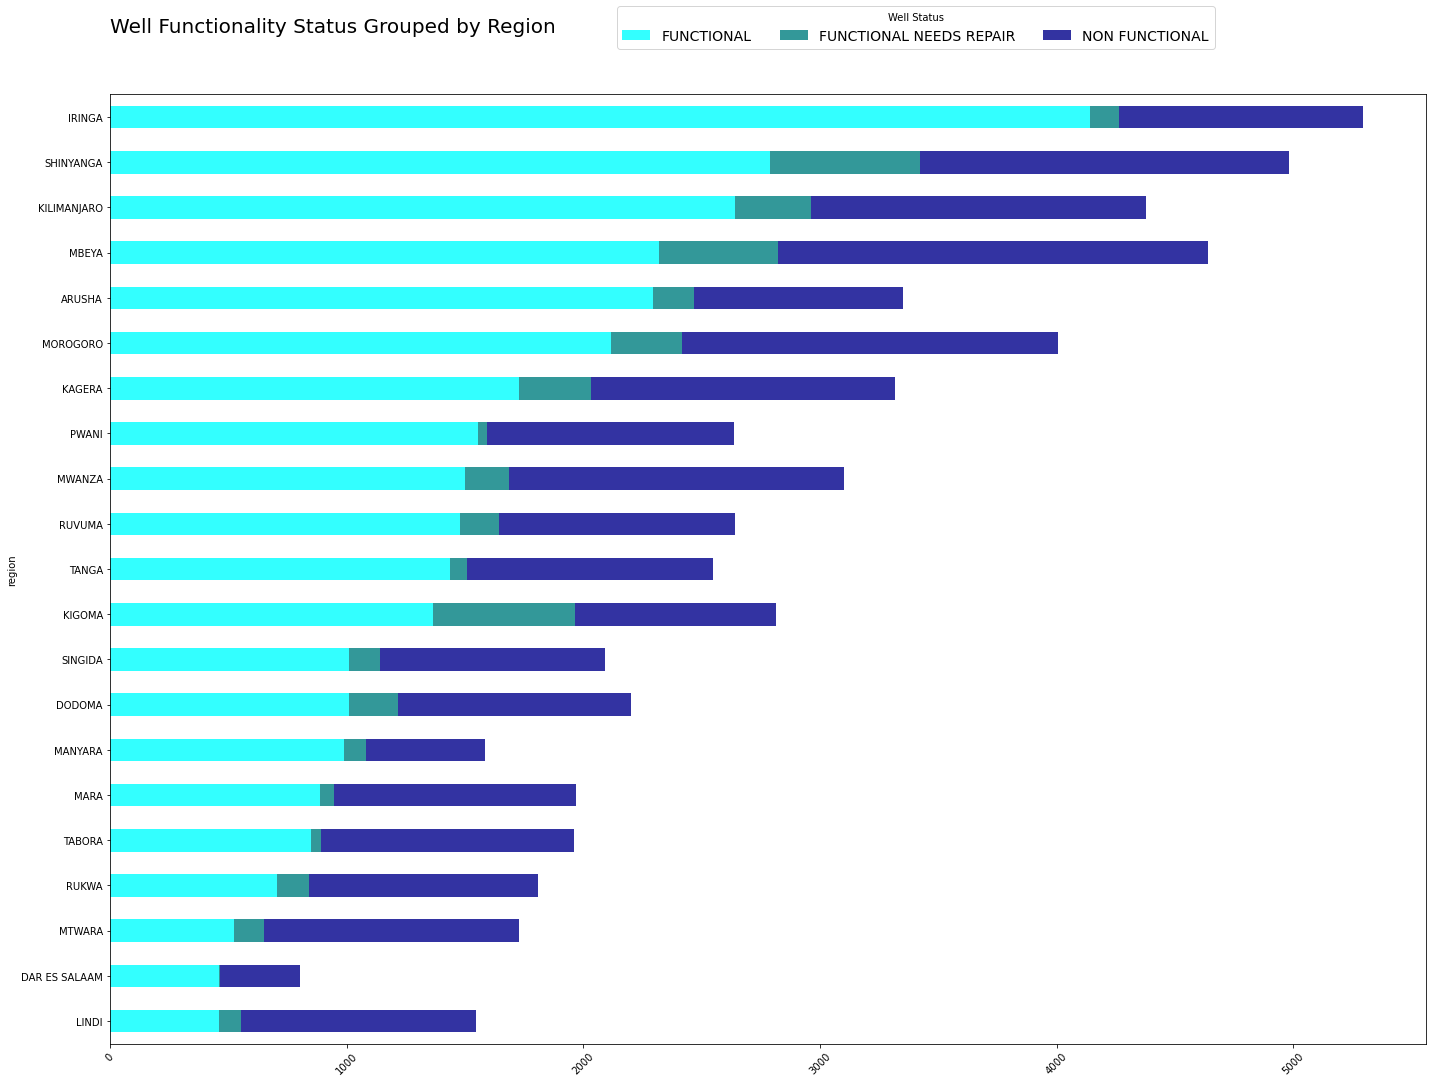

In [82]:
table = pd.crosstab(df['region'], df['status_group']).sort_values(by='FUNCTIONAL')
title = 'Well Functionality Status Grouped by Region\n'
plot_stackedbar(table, title, (20,15))

- **Iringa** has the most number of wells and functional wells proportion as well.
- **Dar es Salaam** has the least no of wells
- **Lindi** has more wells than **Dar es Salaam**, but yet a very high portion of them are `non functional`.

 ` Well functionality status by basin`

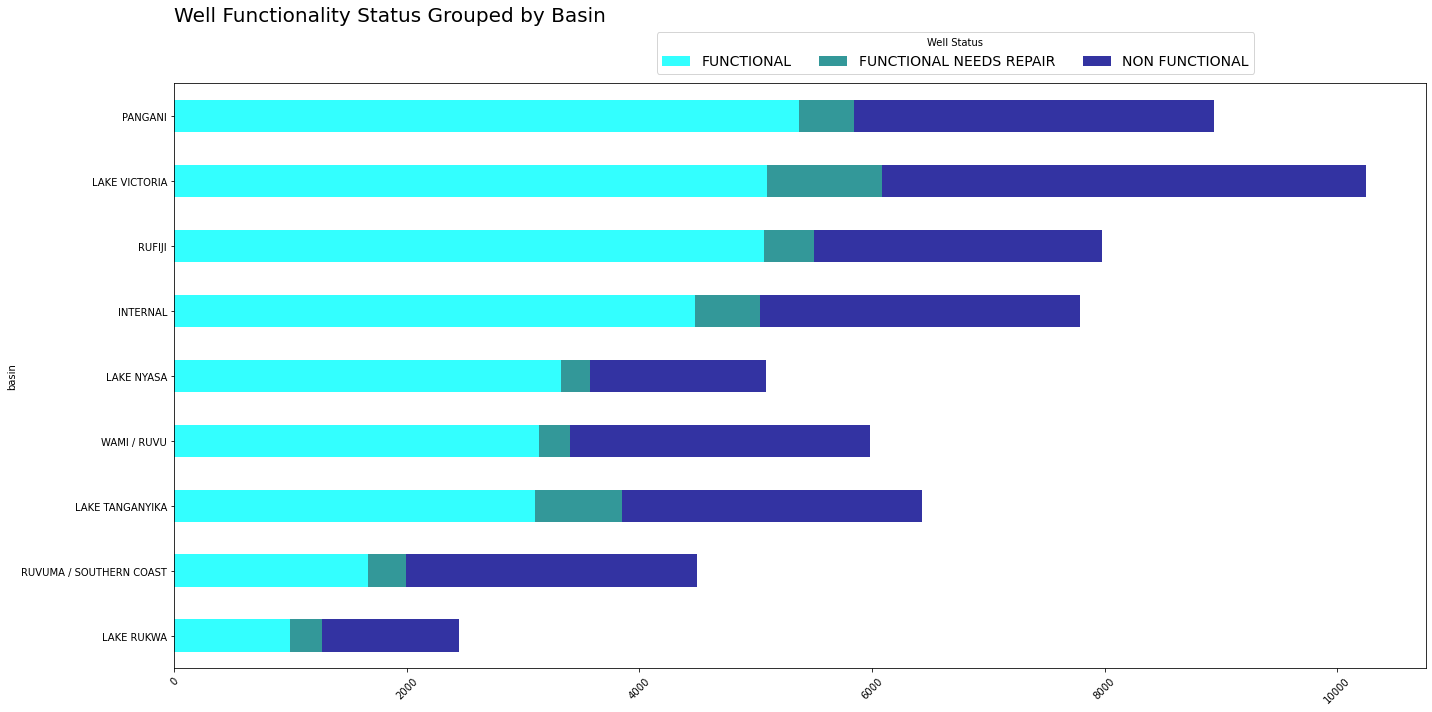

In [95]:
table = pd.crosstab(df['basin'], df['status_group']).sort_values(by='FUNCTIONAL')
title = 'Well Functionality Status Grouped by Basin\n'
plot_stackedbar(table, title, (20,10))

- Ruvuma/Southern coast seems to have the basin with the highest number of non-functional wells in comparison to its population

` Well functionality status by Quantity`

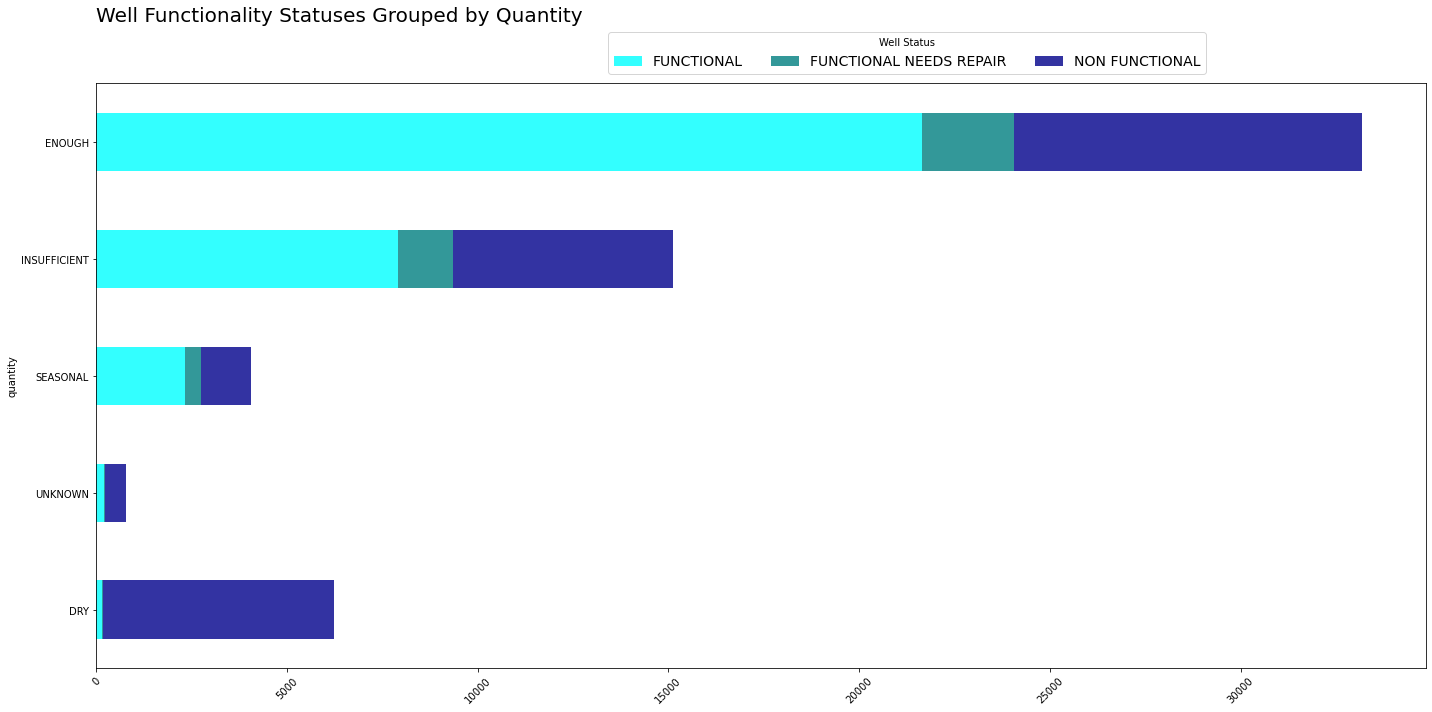

In [92]:
table = pd.crosstab(df['quantity'], df['status_group']).sort_values(by='FUNCTIONAL')
title = 'Well Functionality Statuses Grouped by Quantity\n'
plot_stackedbar(table, title, (20,10))

- **Dry** wells are oftenly *non-functional* as observed.
- **Unknown group**, has more *non-functional* well than the overall population. Since unknown lacks some data, this may indicate poor management and that the well may not well be taken care of

` Well functionality status by waterquality`

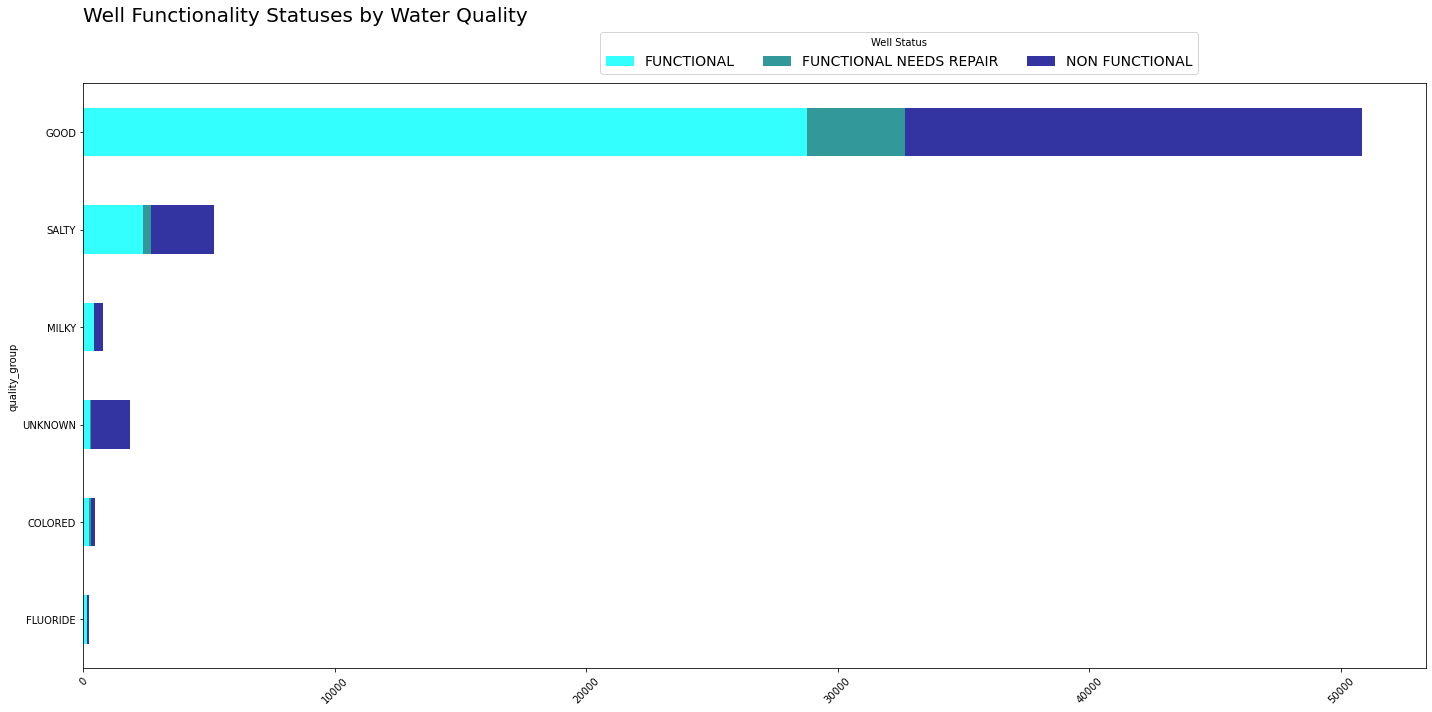

In [93]:
table = pd.crosstab(df['quality_group'], df['status_group']).sort_values(by='FUNCTIONAL')
title = 'Well Functionality Statuses by Water Quality\n'
plot_stackedbar(table, title, (20,10))

- In terms of quality, unknown group still has the highest percentage of non-functional wells in comparison to its population

` Well functionality status by extraction type`

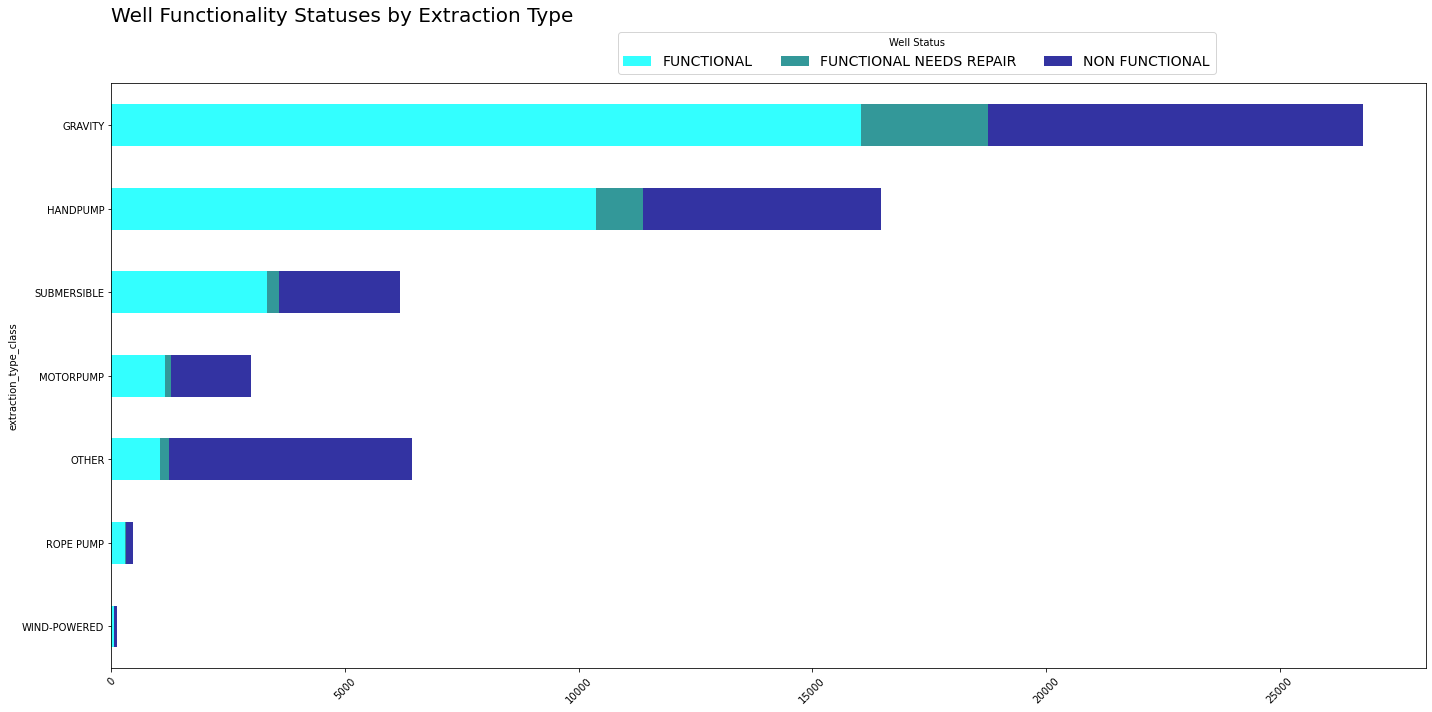

In [97]:
table = pd.crosstab(df['extraction_type_class'], df['status_group']).sort_values(by='FUNCTIONAL')
title = 'Well Functionality Statuses by Extraction Type\n'
plot_stackedbar(table, title, (20,10))

` Well functionality status by waterpoint_type`

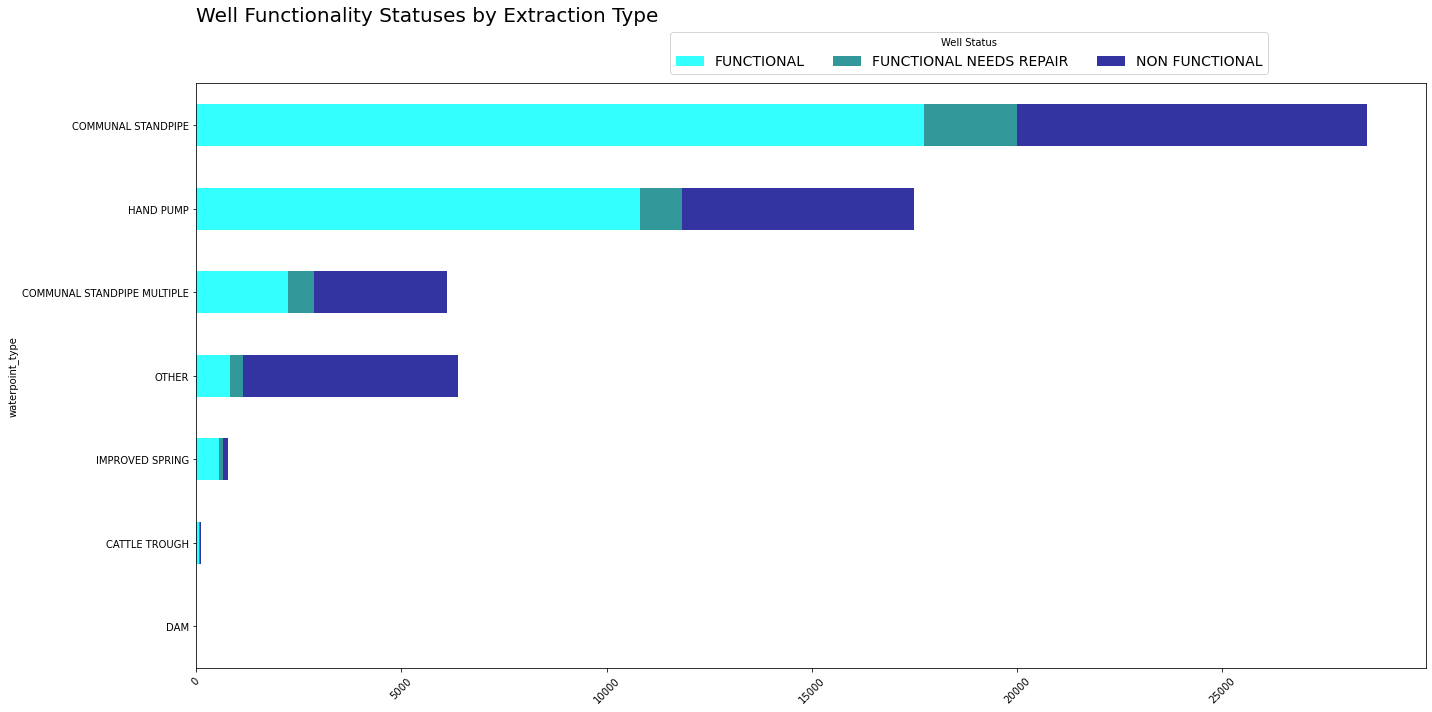

In [98]:
table = pd.crosstab(df['waterpoint_type'], df['status_group']).sort_values(by='FUNCTIONAL')
title = 'Well Functionality Statuses by Extraction Type\n'
plot_stackedbar(table, title, (20,10))

` Well functionality status by source_class`

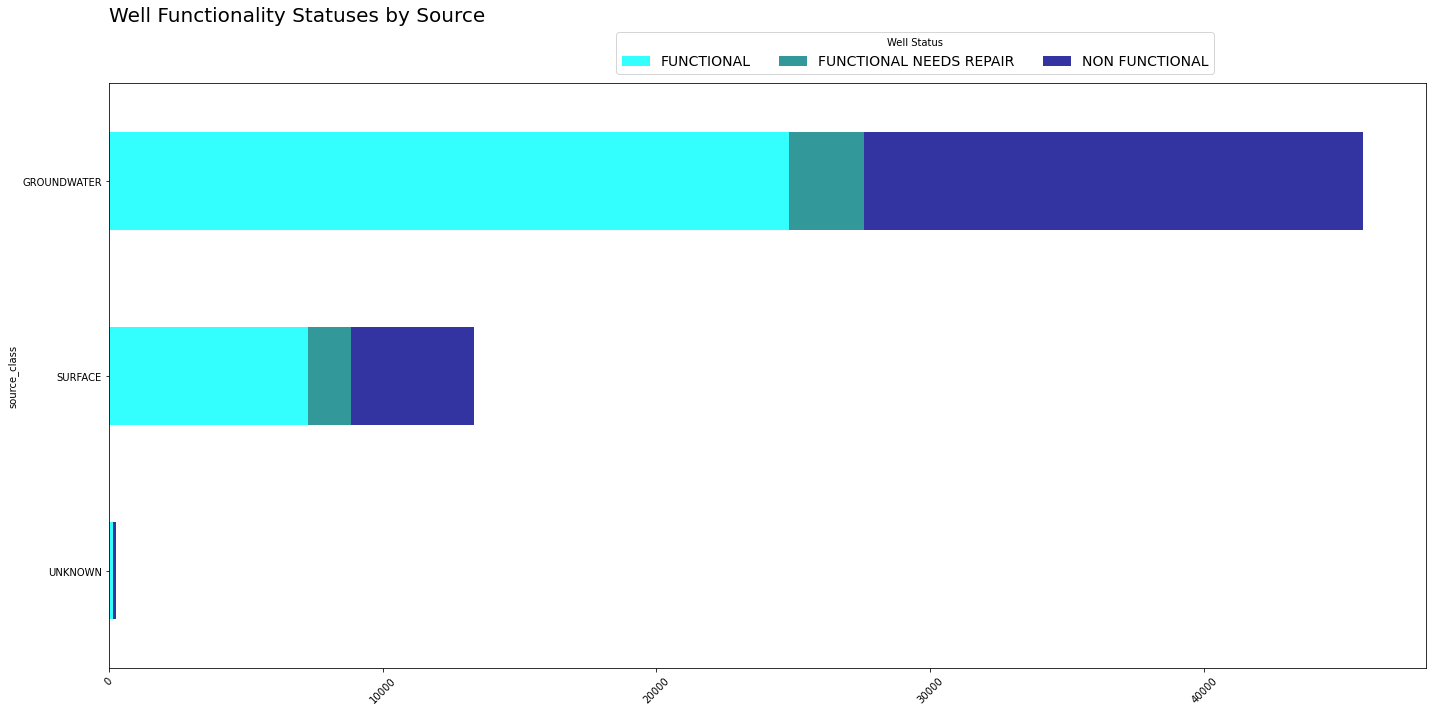

In [99]:
table = pd.crosstab(df['source_class'], df['status_group']).sort_values(by='FUNCTIONAL')
title = 'Well Functionality Statuses by Source\n'
plot_stackedbar(table, title, (20,10))

` Well functionality status by payment`

In [101]:
payment_table = pd.crosstab(df['payment_type'], df['status_group'], normalize='index')\
                        .sort_values(by='FUNCTIONAL', ascending=False)
payment_table

status_group,FUNCTIONAL,FUNCTIONAL NEEDS REPAIR,NON FUNCTIONAL
payment_type,,,
ANNUALLY,0.752334,0.067820,0.179846
PER BUCKET,0.677796,0.045520,0.276683
MONTHLY,0.660482,0.111687,0.227831
ON FAILURE,0.620593,0.070772,0.308636
OTHER,0.579696,0.111954,0.308349
NEVER PAY,0.448911,0.075233,0.475856
UNKNOWN,0.432512,0.052961,0.514527


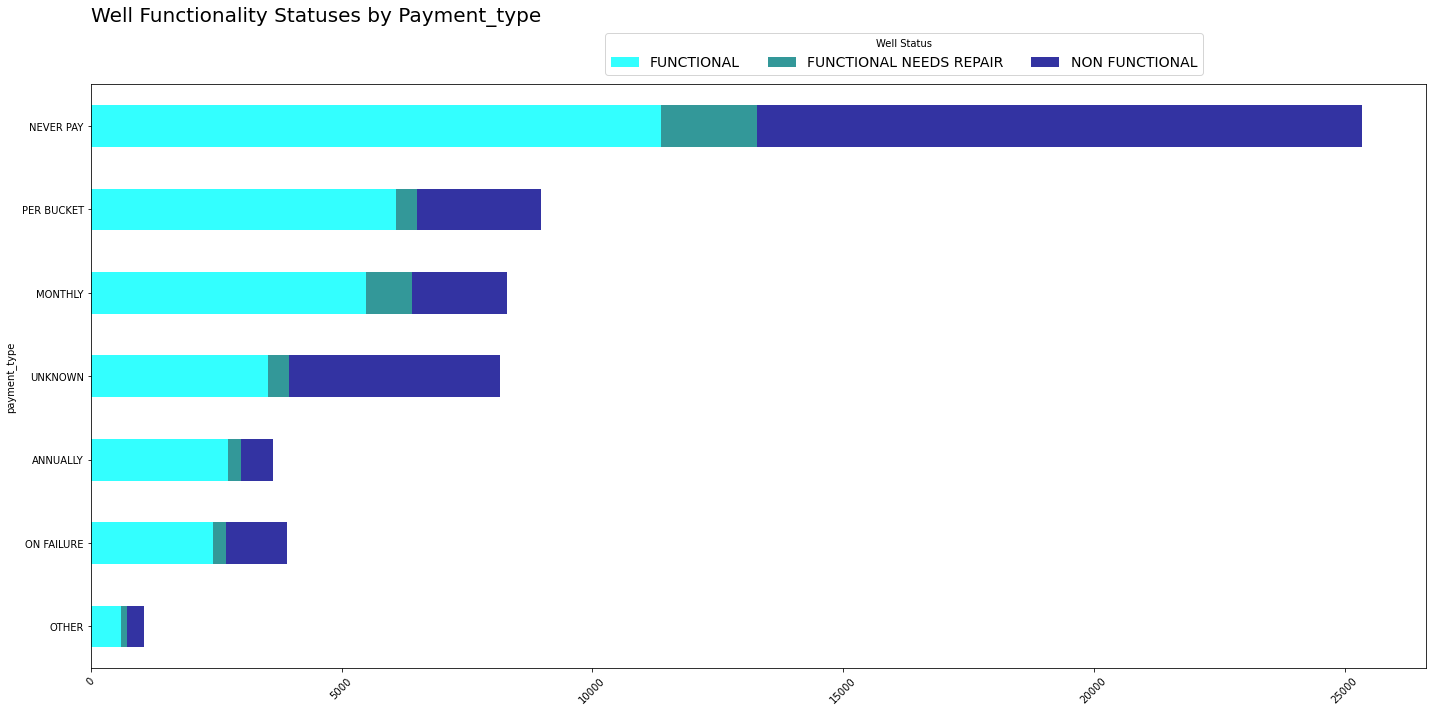

In [100]:
table = pd.crosstab(df['payment_type'], df['status_group']).sort_values(by='FUNCTIONAL')
title = 'Well Functionality Statuses by Payment_type\n'
plot_stackedbar(table, title, (20,10))


- Unknown category has the highest no of non-functional wells

### **Binary Classification**

The dataset is a case of **ternary classification**. I will recategorize the `NON FUNCTIONAL` and `FUNCTIONAL NEEDS REPAIR` in order to perform **binary classification**.This will help with to balance out the rare class `FUNCTIONAL NEEDS REPAIR`which was observed to be underperforming in the ternary classifier as shown in our [ternary model](./notebooks/3.0%20Ternary%20Modelling.ipynb).

In [102]:
# create a copy of our dataset to use for modelling
df_binary = df.copy()

#### Recatecorize Target Variable to Binary class
- Functional -> 0 , Non-functional -> 1 , Functional Needs Repair ->1

In [104]:
# Function to recategorize variables
def recategorize_target_variable(df, target_column, new_column):
   
    df[new_column] = df[target_column].apply(lambda x: 0 if x == 'FUNCTIONAL' else 1)
    return df

In [108]:
# recategorizing class using our function
df_binary = recategorize_target_variable(df_binary, target_column='status_group', new_column='status_group_binary')
print("Binary Target Variable Distribution:")
print(df_binary['status_group_binary'].value_counts())

Binary Target Variable Distribution:
0    32259
1    27141
Name: status_group_binary, dtype: int64


In [109]:
# Creating a new dataframe to be used in binary classification
df1 = df_binary.drop('status_group',axis = 1)
df1.to_csv ('./data/df_binary.csv',index = False)

#### **Data Processing**

In [110]:
# Load data
df = pd.read_csv("./data/df_binary.csv")

# Initialize DataProcessor
processor = DataProcessor(df, target_column="status_group_binary")

# Process the data
processor.process_data()

# Access processed data
X_train = processor.X_train
X_test = processor.X_test
y_train = processor.y_train_encoded
y_test = processor.y_test_encoded

print("Processed training and testing data are ready.")


### Splitting Data ###
Training set size: 47520 rows
Testing set size: 11880 rows

### Encoding Categorical and Boolean Columns with Balanced Approach ###
Boolean columns: []
Categorical columns: ['funder', 'installer', 'basin', 'region', 'lga', 'public_meeting', 'scheme_management', 'permit', 'extraction_type_class', 'management_group', 'payment_type', 'quality_group', 'quantity', 'source_class', 'waterpoint_type']
Balanced encoding completed successfully.
Target Encoding Mapping:
{0: 0, 1: 1}
Data processing completed successfully.
Processed training and testing data are ready.


#### **Fitting Models**

##### **Dummy classifier as the Initial test model**

In [112]:
# Initialize the dummy classifier
dummy_clf = DummyClassifier(strategy="stratified", random_state=42)  # Predicts according to the training set’s class distribution

# Train the dummy classifier
dummy_clf.fit(X_train, y_train)

# Predict on the test set
y_pred_dummy = dummy_clf.predict(X_test)

# Evaluate performance
print("Dummy Classifier Accuracy:", accuracy_score(y_test, y_pred_dummy))
print("\nClassification Report for Dummy Classifier:")
print(classification_report(y_test, y_pred_dummy))

Dummy Classifier Accuracy: 0.4968013468013468

Classification Report for Dummy Classifier:
              precision    recall  f1-score   support

           0       0.54      0.54      0.54      6457
           1       0.45      0.44      0.45      5423

    accuracy                           0.50     11880
   macro avg       0.49      0.49      0.49     11880
weighted avg       0.50      0.50      0.50     11880



- Our dummy classifier with its limitation of using class distribution produced a 50% accuracy. 

##### **Logistic Regression as the baseline model** 
- Will there be any improvement in our baseline model from our simple dummy classifier?

In [113]:
# Train Logistic Regression
regr = LogisticRegression()
regr.fit(X_train, y_train)

# Predict on test data
y_pred = regr.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6829124579124579
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.81      0.73      6457
           1       0.70      0.54      0.61      5423

    accuracy                           0.68     11880
   macro avg       0.69      0.67      0.67     11880
weighted avg       0.69      0.68      0.68     11880



c:\Users\ADMIN\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


- We observe 68% accuracy, a 18% improvement from the dummy classifier. We also note that the recall for the defective wells(1) is low (0.54) when compared to 0.81 for the functional wells

##### **Decision Trees**
- Still on the lookout on the model which will give us best accuracy without any tweeking

In [115]:
# Initialize the Decision Tree classifier
decision_tree = DecisionTreeClassifier(random_state=42)

# Train the Decision Tree classifier
decision_tree.fit(X_train, y_train)

# Predict on the test set
y_pred_decision_tree = decision_tree.predict(X_test)

# Evaluate the Decision Tree
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_decision_tree))
print("\nClassification Report for Decision Tree:")
print(classification_report(y_test, y_pred_decision_tree))

Decision Tree Accuracy: 0.765993265993266

Classification Report for Decision Tree:
              precision    recall  f1-score   support

           0       0.79      0.78      0.78      6457
           1       0.74      0.75      0.75      5423

    accuracy                           0.77     11880
   macro avg       0.76      0.76      0.76     11880
weighted avg       0.77      0.77      0.77     11880



- Definitely an improvement with an accuracy of 76%, we also note general improvement of recall for the defective wells, however the functional wells recall has dropped. Generally, there is balance on metrics for 0s and 1s in this model

##### **Random Forest**

- Lets look at one more model before we choose one to improve on 

In [116]:
# Initialize the Random Forest classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the Random Forest classifier
random_forest.fit(X_train, y_train)

# Predict on the test set
y_pred_random_forest = random_forest.predict(X_test)

# Evaluate the Random Forest
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_random_forest))
print("\nClassification Report for Random Forest:")
print(classification_report(y_test, y_pred_random_forest))

Random Forest Accuracy: 0.8155723905723906

Classification Report for Random Forest:
              precision    recall  f1-score   support

           0       0.82      0.85      0.83      6457
           1       0.82      0.77      0.79      5423

    accuracy                           0.82     11880
   macro avg       0.82      0.81      0.81     11880
weighted avg       0.82      0.82      0.82     11880



**Key Observations:**
- The `Random Forest` significantly outperforms the `Decision Tree` and `Logistic Regression` in both accuracy and F1-scores.
- It maintains a good balance across both classes.
- `Precision` and `Recall` for Class 0 (Functional) and Class 1 (Non-functional/Needs Repair) are more robust, making this model the most reliable so far.
- We will thus move forward to improve on the Random Forest Model

##### **Overfitting Check**

In [118]:
# Training accuracy
train_preds = random_forest.predict(X_train)
train_accuracy = accuracy_score(y_train, train_preds)

# Testing accuracy
test_preds = random_forest.predict(X_test)
test_accuracy = accuracy_score(y_test, test_preds)

print(f"Training Accuracy: {train_accuracy}")
print(f"Testing Accuracy: {test_accuracy}")

Training Accuracy: 0.9972011784511785
Testing Accuracy: 0.8155723905723906


Cross validation

In [120]:
scores = cross_val_score(random_forest, X_train, y_train, cv=5)
print(f"Cross-Validation Scores: {scores}")
print(f"Mean CV Score: {scores.mean()}")

Cross-Validation Scores: [0.81428872 0.81544613 0.81818182 0.82081229 0.81460438]
Mean CV Score: 0.8166666666666668


**Overfitting Insights**

- Despite the consistent cross-validation values, the large gap between training and testing data suggest overfitting.The cross-validation suggests that models generalizability is stable, however there may be a problem with model complexity.

To improve our model we may need to :
- Simplify the model
- Reduce number of less important features
- Perform hyperparameter tuning
 



Random Forest Feature Importance

In [121]:
# Extract feature importance
feature_importances = random_forest.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the top features
print(importance_df)

                                        Feature  Importance
5                                      latitude    0.143206
4                                     longitude    0.141770
2                                    gps_height    0.071401
10                            construction_year    0.056228
1                                        funder    0.051371
8                                    population    0.047757
43                              quantity_ENOUGH    0.045127
3                                     installer    0.042274
54                        waterpoint_type_OTHER    0.036113
7                                           lga    0.034647
0                                    amount_tsh    0.027956
6                                        region    0.025256
24                  extraction_type_class_OTHER    0.025192
44                        quantity_INSUFFICIENT    0.023051
9                             scheme_management    0.018957
49           waterpoint_type_COMMUNAL ST

To determine which features to drop we will have a look at the below:
- Correlation Analyis
- Low variance Features

Correlation Analysis

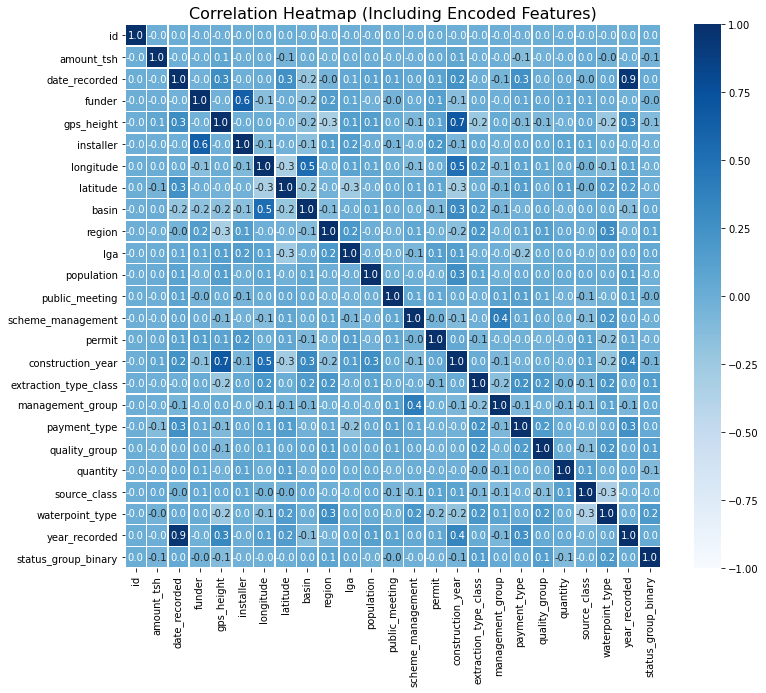

In [128]:
# Copy the DataFrame to avoid altering the original
df_encoded = df.copy()

# Identify categorical (object) columns
categorical_columns = df.select_dtypes(include=['object']).columns

# Apply Label Encoding for simplicity
for col in categorical_columns:
    le = LabelEncoder()
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

# Compute correlation matrix
correlation_matrix = df_encoded.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with a color bar
sns.heatmap(correlation_matrix, 
            annot=True,  # Display correlation values
            fmt=".1f",   # Format of the correlation values
            cmap = "Blues",  # Colormap
            linewidths=0.5,  # Add gridlines
            vmin=-1, vmax=1)  # Range of values

plt.title("Correlation Heatmap (Including Encoded Features)", fontsize=16)
plt.show()


- Most features have very weak correlation

Low Variance Features

In [130]:
# Apply VarianceThreshold
selector = VarianceThreshold(threshold=0.01)  # Adjust threshold based on data
selector.fit(X_train)

# Features to keep
features_to_keep = X_train.columns[selector.get_support()]
features_to_drop = X_train.columns[~selector.get_support()]

print("Low variance features to drop:", list(features_to_drop))

Low variance features to drop: ['extraction_type_class_ROPE PUMP', 'extraction_type_class_WIND-POWERED', 'management_group_UNKNOWN', 'quality_group_FLUORIDE', 'source_class_UNKNOWN', 'waterpoint_type_DAM']


Random Forest with Feature Selection

In [131]:
#Transform the datasets
X_train_reduced = selector.transform(X_train)
X_test_reduced = selector.transform(X_test)

# Get the features that were retained
features_to_keep = X_train.columns[selector.get_support()]
features_to_drop = X_train.columns[~selector.get_support()]

# Convert back to DataFrame for clarity
X_train_reduced = pd.DataFrame(X_train_reduced, columns=features_to_keep, index=X_train.index)
X_test_reduced = pd.DataFrame(X_test_reduced, columns=features_to_keep, index=X_test.index)

#Train the Random Forest Model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_reduced, y_train)

#Evaluate the Model
y_pred = rf_model.predict(X_test_reduced)

print("New Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

New Model Accuracy: 0.8127946127946128

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.85      0.83      6457
           1       0.81      0.77      0.79      5423

    accuracy                           0.81     11880
   macro avg       0.81      0.81      0.81     11880
weighted avg       0.81      0.81      0.81     11880



In [133]:
# Evaluate Training Accuracy
train_accuracy_1 = rf_model.score(X_train_reduced, y_train)

# Evaluate Testing Accuracy
test_accuracy_1 = rf_model.score(X_test_reduced, y_test)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")

# Assess Overfitting
if train_accuracy_1 > test_accuracy_1 + 0.1:  # Adjust threshold if necessary
    print("\nThe model might be overfitting!")
else:
    print("\nThe model does not show significant overfitting.")

Training Accuracy: 0.9972
Testing Accuracy: 0.8128

The model might be overfitting!


- With Feature importance where we drop low variance values, overfitting was still observed

### **Hyperparameter Tuning for Random Forest**

In [136]:
# Parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [None, 10, 20, 30],  # Depth of trees
    'min_samples_split': [2, 5, 10],  # Min samples to split a node
    'min_samples_leaf': [1, 2, 4]     # Min samples at a leaf node
}

In [137]:
# Initialize Random Forest
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,  # 3-fold cross-validation
    scoring='accuracy',  # Evaluate using accuracy
    verbose=2,  # Show progress
    n_jobs=-1  # Use all processors
)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)


Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy', verbose=2)

In [138]:
# Best hyperparameters
print("Best Parameters:", grid_search.best_params_)

# Best score from GridSearchCV
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Best Parameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best Cross-Validation Accuracy: 0.8202441077441077


**Evaluating best Random Forest Model**

In [139]:
# Train the best Random Forest model
best_rf = grid_search.best_estimator_

# Predict on the test set
y_pred_best_rf = best_rf.predict(X_test)

# Evaluate performance
from sklearn.metrics import classification_report, accuracy_score

print("Random Forest Accuracy (Best Model):", accuracy_score(y_test, y_pred_best_rf))
print("\nClassification Report (Best Model):")
print(classification_report(y_test, y_pred_best_rf))

Random Forest Accuracy (Best Model): 0.8205387205387206

Classification Report (Best Model):
              precision    recall  f1-score   support

           0       0.82      0.87      0.84      6457
           1       0.83      0.77      0.80      5423

    accuracy                           0.82     11880
   macro avg       0.82      0.82      0.82     11880
weighted avg       0.82      0.82      0.82     11880



- Best RF model has an accuracy score of 82 %, while the original model(without hyperparameters) also had 82% accuracy score.


In [140]:
# Training accuracy
y_train_pred = best_rf.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

# Testing accuracy
test_accuracy = accuracy_score(y_test, y_pred_best_rf)
print("Testing Accuracy:", test_accuracy)

Training Accuracy: 0.9590277777777778
Testing Accuracy: 0.8205387205387206


**Comparison Random Forest Model Vs Hypertuned Random Forest Model**

Confusion Matrix

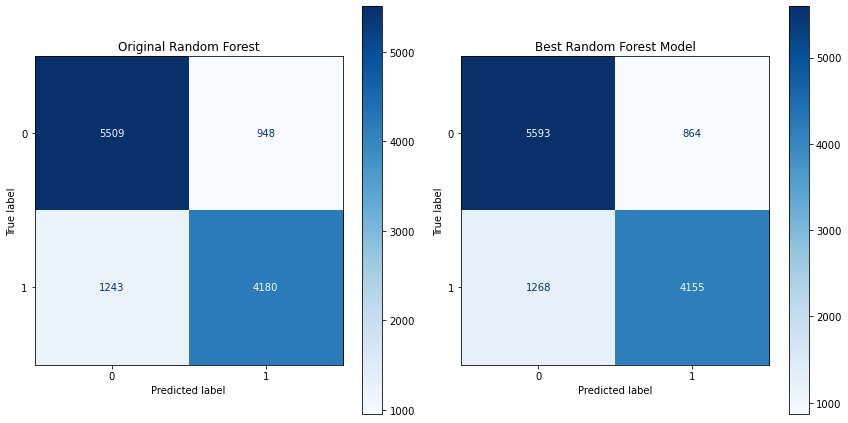

In [142]:
# Compute confusion matrices
cm_rf = confusion_matrix(y_test, y_pred_random_forest)
cm_best_rf = confusion_matrix(y_test, y_pred_best_rf)

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Confusion matrix for the original Random Forest model
ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=[0, 1]).plot(
    ax=axes[0], cmap="Blues"
)
axes[0].set_title("Original Random Forest")

# Confusion matrix for the best Random Forest model
ConfusionMatrixDisplay(confusion_matrix=cm_best_rf, display_labels=[0, 1]).plot(
    ax=axes[1], cmap="Blues"
)
axes[1].set_title("Best Random Forest Model")

plt.tight_layout()
plt.show()


### **Conclusion and Recommendation**
*Performance*
- Both models performed similarly, with the best model slightly outperforming the initial random forest in terms of precision and recall for Class 1 (Non-functional/Needs Repair).
The best model's accuracy is marginally higher at 82% compared to the initial model's 81.6%

*Class 0 was very dominant*, indicated by high recall and precision values. This shows the models were more effective at predicting functional wells than wells that actually require repair class(1).
- There is room for improvement to ensure model properly predict class 1 

##### **Recommendation**
- Focus on class 1 improvement by using advanced techniques such class weighting to improve on dataset balance.
- Further analyze feature importance to actually understand which variable are really driving predictions.
- Explore advanced ensemble methods such as boosting, inorder to optimize models ability to predict minority class.
- Data quality: Engage with key stakeholders to ensure quality data is collected, to ensure proper handling of outliers or missing values in future with data quality controls put in place.
- Deployment and Monitoring: Develop a robust system for deploying the model into a production environment and monitor its performance over time. 